### Import libraries

In [ ]:
import glob as glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

In [2]:
import glob as glob
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.1


### Preparing Data for Training

In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size, img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="binary",  # Binary classification for wrinkles
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                         target_size=(img_size, img_size),
                                                         color_mode="grayscale",
                                                         batch_size=batch_size,
                                                         class_mode="binary",  # Binary classification for wrinkles
                                                         shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Defining Model

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    return x

In [5]:

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
def model_wrinkle(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3, 3))
    conv_2 = Convolution(conv_1, 64, (5, 5))
    conv_3 = Convolution(conv_2, 128, (3, 3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)

    output = Dense(1, activation="sigmoid")(dense_1)  # Sigmoid for binary classification
    model = Model(inputs=[inputs], outputs=[output])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [7]:
model = model_wrinkle((48, 48, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

### Initializing the Model

In [8]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights_wrinkle.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

### Training the Model

In [9]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: -130.8603 - accuracy: 0.0194
Epoch 1: saving model to model_weights_wrinkle.h5
448/448 [==============================] - 1254s 3s/step - loss: -130.8603 - accuracy: 0.0194 - val_loss: -364.0212 - val_accuracy: 0.0155
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: -892.9717 - accuracy: 0.0152
Epoch 2: saving model to model_weights_wrinkle.h5
448/448 [==============================] - 550s 1s/step - loss: -892.9717 - accuracy: 0.0152 - val_loss: -1739.2904 - val_accuracy: 0.0155
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: -2418.3376 - accuracy: 0.0152
Epoch 3: saving model to model_weights_wrinkle.h5
448/448 [==============================] - 360s 804ms/step - loss: -2418.3376 - accuracy: 0.0152 - val_loss: -3591.0007 - val_accuracy: 0.0155
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: -4600.0591 - accuracy: 0.0152
Epoch 4: saving model to model_

### Model Evaluation

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 114s 1s/step - loss: -56737.8750 - accuracy: 0.0155


[-56737.875, 0.015463917516171932]

### Plotting Loss

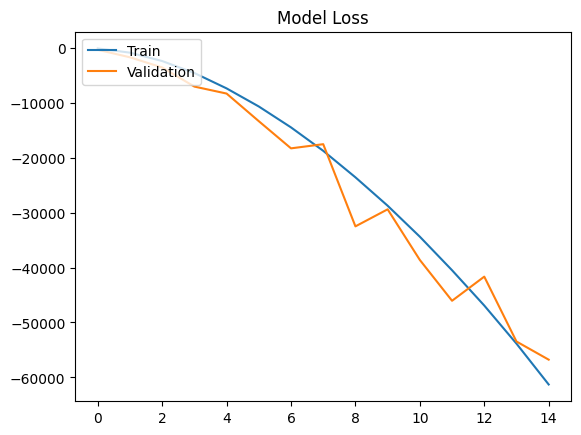

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

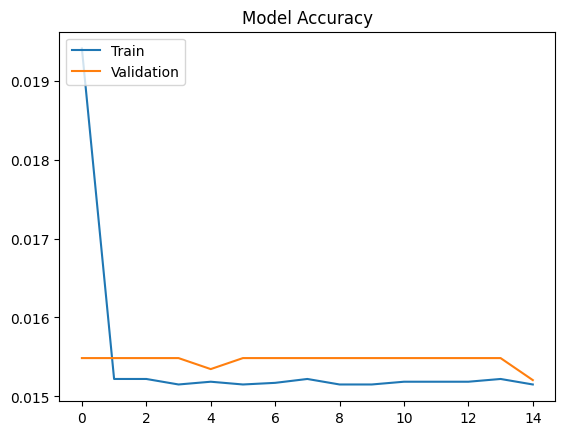

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Saving Model

In [13]:
model_json = model.to_json()
with open("model_wrinkle.json", "w") as json_file:
    json_file.write(model_json)